# 7-1_TensorFlow/Kerasによる画像分類
このノートブックではTensorFlow / Keras を用いて画像分類を行うモデルを作成します。<br>
テーマはMNISTという手書きの数字を0～9のどれなのか判別するものです。

画像データを分類する場合には、画像を同じサイズに準備したり、ラベル付けの作業を事前に行っておく必要がありますが、今回はデータセットとしてすでに用意してあります。また、これまでの構造化データとは違い、説明変数は画像の各ピクセルのみです。データの範囲や説明変数の数はすでに分かっているので、データについて詳細に確認する作業は省略し、必要な作業に絞ってプログラミングしていきます。

## ランタイムをGPUに切り替える
画像分類では非常に多くのコンピューティングリソースを使うため、CPUではとても時間がかかってしまいます。
そこで、Google ColaboratoryのランタイムをGPUに切り替えます。

ランタイムをGPUに切り替えるには、上部のメニューから「ランタイム > ランタイムのタイプを変更」を選択し、ハードウェアアクセラレーターでGPUを選択して、保存をクリックします。

Kerasの場合は自動的にランタイムを判断して、GPUが使用できる場合にはGPUを使用して演算を行います。

## ライブラリのインポート

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Keras / TensorFlow関連のライブラリ
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist

## MNISTのダウンロードおよびデータの準備
Kerasのデータセットを使ってMNISTのデータをダウンロードします。

MNISTは0から9までの手書き数字画像データ7万件です。

訓練データ6万件と検証データ1万件に最初から分けてあるので、それぞれ変数に格納します。



In [ ]:
# MNISTをロードする
(train_images, train_labels), (val_images, val_labels) = mnist.load_data()

In [ ]:
# 訓練データの件数
len(train_images)

60000

In [ ]:
# 検証データの件数
len(val_images)

10000

変数に格納したデータは60000×28×28のnumpy配列として格納されています。<br>
これを255で割ることにより、一つ一つのピクセル情報を0～1の範囲に正規化します。<br>
画像の場合は必ず0～255の範囲に収まるため単純に割り算を行うことで正規化できます。

In [ ]:
# ロード直後のデータの形状を確認する
train_images.shape

(60000, 28, 28)

In [ ]:
# 一件目のデータを確認する
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [ ]:
# 訓練データをfloat型に直し、255で割って正規化
train_images = train_images.astype("float32") / 255.

In [ ]:
# 変換後のデータを確認する
train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [ ]:
# 検証データも正規化
val_images = val_images.astype("float32") / 255.

In [ ]:
# 目的変数である、0～9のどれに当たるかのラベルをone-hot表現に直します。
# 変換はKerasのユーティリティ機能を使用します。
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
val_labels = tf.keras.utils.to_categorical(val_labels, 10)

In [ ]:
# 変換後の目的変数の先頭10件を確認する
train_labels[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

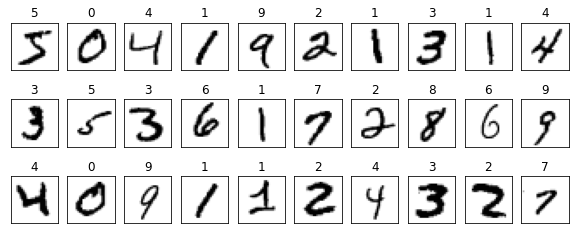

In [ ]:
# (参考)ダウンロードしたイメージを表示してみる
fig = plt.figure(figsize=(10, 4)) # 図のサイズを指定する
count = 0
for (image, label) in zip(train_images, train_labels): # ひとつづつイメージとラベルを取り込みながら繰り返す
    subplot = fig.add_subplot(3, 10, count + 1) # 3行10列の領域に区切り、一つ目から順番に画像を当てはめていく
    subplot.set_title(np.argmax(label)) # 正解ラベルを設定
    subplot.set_xticks([]) # x軸目盛を非表示
    subplot.set_yticks([]) # y軸目盛を非表示
    subplot.imshow(image.reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r) # 画像を表示
    count = count + 1
    if count >= 30: # 30個の画像を表示したら終了する
      break
plt.show()

## モデルの定義
- モデルの概要
  - 畳み込み層(16チャネル)
    - 畳み込みカーネル 5×5
    - パディングにより畳み込み後にサイズを小さくしない
    - 活性化関数はReLUを使用（カーネル通過後の特徴をより際立たせる）
  -プーリング層(16チャネル)
    - マックスプーリング 2×2
  - 全結合層(1024)
  - 出力層(10)



In [ ]:
# GPUを使用する場合は乱数シードを固定しても、学習の過程で結果が少し異なる場合があります。
tf.random.set_seed(0)

model = Sequential()

# 畳み込み層
model.add(Conv2D(16, (5, 5), padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# プーリング層
model.add(MaxPooling2D((2, 2)))
# 全結合層
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 出力層
model.add(Dense(10))
model.add(Activation('softmax'))

# 最適化手法としてAdam、誤差関数として交差エントロピー誤差を設定
# metricsは損失以外に実行中に確認する評価指標を指定できる。
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

# モデルの形状を確認
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 activation (Activation)     (None, 28, 28, 16)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1024)              3212288   
                                                        

## 学習

In [ ]:
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), batch_size=256, epochs=10)

Epoch 1/10
235/235 [==============================] - 4s 8ms/step - loss: 0.2362 - acc: 0.9296 - val_loss: 0.1056 - val_acc: 0.9792
Epoch 2/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0802 - acc: 0.9755 - val_loss: 0.0732 - val_acc: 0.9831
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0582 - acc: 0.9819 - val_loss: 0.0543 - val_acc: 0.9881
Epoch 4/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0473 - acc: 0.9844 - val_loss: 0.0494 - val_acc: 0.9867
Epoch 5/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0394 - acc: 0.9876 - val_loss: 0.0396 - val_acc: 0.9898
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0320 - acc: 0.9894 - val_loss: 0.0358 - val_acc: 0.9898
Epoch 7/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0286 - acc: 0.9910 - val_loss: 0.0317 - val_acc: 0.9913
Epoch 8/10
235/235 [==============================] - 2s 7ms/step - loss: 0.

## 評価

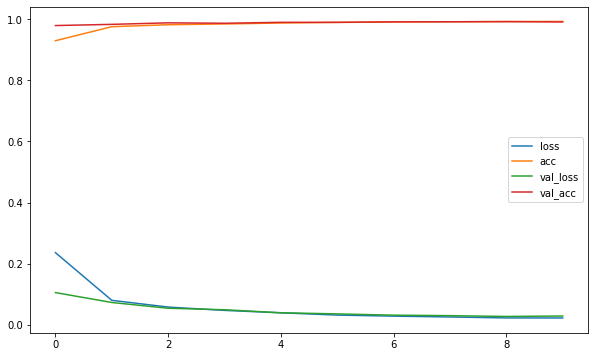

In [ ]:
# 損失、正解率を可視化する
df_history = pd.DataFrame(history.history)
df_history.plot(figsize=(10, 6))

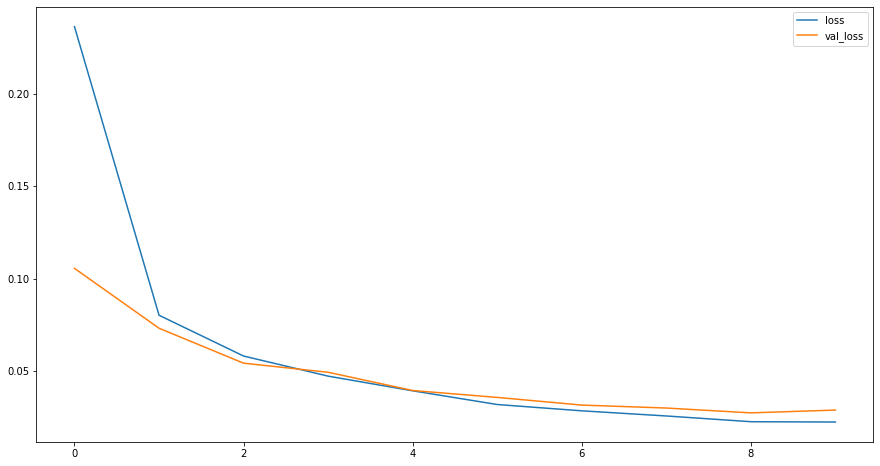

In [ ]:
# （参考）グラフを整形する
# 損失
pd.DataFrame({'loss': history.history['loss'], 
           'val_loss': history.history['val_loss']}).plot(figsize=(15, 8))

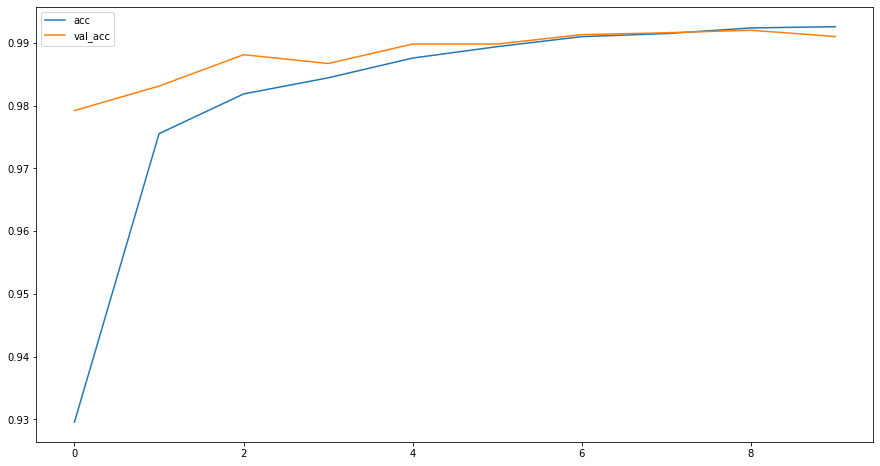

In [ ]:
# （参考）グラフを整形する
# 正解率
pd.DataFrame({'acc': history.history['acc'], 
           'val_acc': history.history['val_acc']}).plot(figsize=(15, 8))

## 予測を試してみる

1/1 [==============================] - 0s 87ms/step


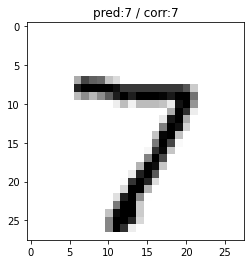

In [ ]:
# n番目のデータに対して予測を行う
n = 0

image = val_images[n]
label = val_labels[n]

p_val = model.predict(np.array([image]))           # 一つの画像の予測確率
prediction = np.argmax(p_val[0])                   # 予測確率が最大のものを取得
correct = np.argmax(label)                         # 正解ラベルも予測確率が最大のものを取得
plt.title(f'pred:{prediction} / corr:{correct}')   # ラベルを設定
plt.imshow(image.reshape((28, 28)), vmin=0, vmax=1, cmap=plt.cm.gray_r) # 画像を表示
plt.show()

（参考）間違いだったデータを確認してみる

1/1 [==============================] - 0s 16ms/step


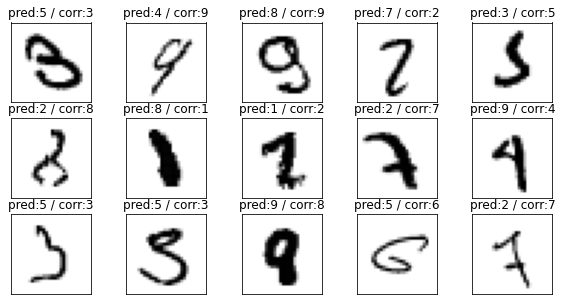

In [ ]:
# 間違いだったデータを確認してみる
fig = plt.figure(figsize=(10, 5)) # 図のサイズを指定する
count = 0
for (image, label) in zip(val_images, val_labels): # ひとつづつイメージとラベルを取り込みながら繰り返す
  p_val = model.predict(np.array([image]))
  prediction = np.argmax(p_val[0])
  correct = np.argmax(label)
  if prediction == correct:
    continue      
  subplot = fig.add_subplot(3, 5, count + 1) # 3行10列の領域に区切り、一つ目から順番に画像を当てはめていく
  subplot.set_title(f'pred:{prediction} / corr:{correct}') # ラベルを設定
  subplot.set_xticks([]) # x軸目盛を非表示
  subplot.set_yticks([]) # y軸目盛を非表示
  subplot.imshow(image.reshape((28, 28)), vmin=0, vmax=1, cmap=plt.cm.gray_r) # 画像を表示
  count = count + 1
  if count >= 15: # 15個の画像を表示したら終了する
    break
plt.show()